# Part 2 - Delivery Network Analysis
__Author__: Jacques Michel, s182244

The objective of this technical report is to analyze and improve the sellers/customers network performance of the [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce). It is written as part of the final challenge in the Advanced Business Analytics course at the Technical University of Denmark.

__Table of content__
* Introduction
* 1. Network definition
* 2. Network Analysis
    * 2.1 Graph construction
    * 2.2 Layout selection
    * 2.3 Visualization and observations
* 3. Delivery network optimization
* Conclusion

## Introduction

In this report, the __Olist business problem__ is to address the challenge of customer satisfaction related to product delivery. In order to do so, __network analysis__ will be used to both define, visualize and analyse the complex network comprised of sellers shipping items to customers.

To assess the delivery performance of a network, three __Key Performance Indicators__ will be used:
1. __Review score__: the score, from one to five, assigned by the customer to the delivered order,
2. __Delivery time__: the time, measured in days, between the approval date of the order and its delivery date,
3. __Delivery distance__: the geographical distance, measured in kilometers, between the seller and the customer.

The report will be divided into three parts. First, the network will be properly defined and the related data processed and formatted. Second, a graph representing the network will be constructed, visualized and analyzed with various layouts and attributes. Finally, the insights provided by the network analysis will be utilized with the purpose of improving customer satisfaction.

__Imports__

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\Users\jacqu\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## <font color=orange>1: </font> Definition of the network

__Each graph $G = (\mathbf{V}, \mathbf{E})$ will consist of a set of nodes $\mathbf{V}$ representing the sellers and customers and a set of directed edges $\mathbf{E}$ representing the items shipped from the sellers by the customers (seller → customer). This definition will be the base of all the networks visualizations in this report.__

In the steps below, the DataFrame containing all the network attributes will be constructed.

In [2]:
#Main dataset
customers      = pd.read_csv(".\\brazilian-ecommerce\\olist_customers_dataset.csv")
geolocation    = pd.read_csv(".\\brazilian-ecommerce\\olist_geolocation_dataset.csv")
order_items    = pd.read_csv(".\\brazilian-ecommerce\\olist_order_items_dataset.csv")
order_payments = pd.read_csv(".\\brazilian-ecommerce\\olist_order_payments_dataset.csv")
order_reviews  = pd.read_csv(".\\brazilian-ecommerce\\olist_order_reviews_dataset.csv")
orders         = pd.read_csv(".\\brazilian-ecommerce\\olist_orders_dataset.csv")
products       = pd.read_csv(".\\brazilian-ecommerce\\olist_products_dataset.csv")
sellers        = pd.read_csv(".\\brazilian-ecommerce\\olist_sellers_dataset.csv")

#Marketing dataset
# closed_deals   = pd.read_csv(".\\marketing-funnel-olist\\olist_closed_deals_dataset.csv")
# marketing      = pd.read_csv(".\\marketing-funnel-olist\\olist_marketing_qualified_leads_dataset.csv")

In [3]:
#In order to facilitate calculations, time fields are converted to "datetime" format
orders['order_purchase_timestamp']      = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at']             = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

#Define new temporal attributes
orders['order_month']             = orders['order_approved_at'].apply(lambda x: x.month)
orders['delivery_time_days']      = (orders['order_delivered_customer_date'] - orders['order_approved_at']).apply(lambda x: x.days )
orders['estimated_delivery_days'] = (orders['order_estimated_delivery_date'] - orders['order_approved_at']).apply(lambda x: x.days )
orders['delivery_delay_days']     = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).apply(lambda x: x.days )

The full network will be constituted of a number of unique sellers and a number of unique customers, as shown below.

In [4]:
print("Total sellers:", len(sellers), '| unique:', len(sellers.seller_id.unique()))
print("Total customers:", len(customers), '| unique:', len(customers.customer_id.unique()))
print("Max network size |V| = ", '{:,}'.format(len(sellers)*len(customers)))

Total sellers: 3095 | unique: 3095
Total customers: 99441 | unique: 99441
Max network size |V| =  307,769,895


In order to define the edges $\mathbf{E}$, it will be necessary to join tables to establish the link between sellers and customers. To get a first sense on how to join the tables, it is useful to look at the number of entries.

In [5]:
print("Number of orders:", len(orders))
print("Number unique order ids:", len(orders.order_id.unique()))
print("Number of items ordered:", len(order_items))
print("Number of unique order ids in items table:", len(order_items.order_id.unique()))

Number of orders: 99441
Number unique order ids: 99441
Number of items ordered: 112650
Number of unique order ids in items table: 98666


Furthermore, in order to calculate the travel distances, it is useful to define a function. It has been inspired from [this stackoverflow questions](https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude).

In [6]:
from math import sin, cos, sqrt, atan2, radians

def get_distance(coords):
    R = 6373.0
    lat1 = radians(coords[0])
    lon1 = radians(coords[1])
    lat2 = radians(coords[2])
    lon2 = radians(coords[3])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

#Test example
test = pd.DataFrame({'lat1': [52.2296756], 'lng1': [21.0122287], 'lat2': [52.406374], 'lng2': [16.9251681]})
print("Result expected from Stackoverflow example: 278.545589351 km")
print("Result:", test.apply(get_distance, axis=1).values[0], 'km')

Result expected from Stackoverflow example: 278.545589351 km
Result: 278.54558935106695 km


The main steps of the data-processing can now be performed.

In [7]:
#Merge with items table to get one line per item (and not one line per order)
merged = order_items.merge(right=orders, left_on='order_id', right_on='order_id')
print("Total number of items:", len(merged))

#Merge with products table to get product categories
merged = merged.merge(right=products, left_on='product_id', right_on='product_id')
print("Check number of items:", len(merged))

#Merge with seller and customer tables to get zip codes
merged = merged.merge(right=sellers, left_on='seller_id', right_on='seller_id')
merged = merged.merge(right=customers, left_on='customer_id', right_on='customer_id')
print("Check number of items:", len(merged))

#Merge with geolocations to get seller coordinates
geolocation_mean = geolocation.groupby('geolocation_zip_code_prefix').mean() #In order to avoid duplicates
merged = merged.merge(right=geolocation_mean, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
merged = merged.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'})
print("Check number of items:", len(merged))

#Merge with geolocations to get customer coordinates
merged = merged.merge(right=geolocation_mean, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
merged = merged.rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'})
print("Check number of items:", len(merged))

#Apply the above defined function to get the travel distances
merged['delivery_distance_km'] = merged[['seller_lat', 'seller_lng', 'customer_lat', 'customer_lng']].apply(get_distance, axis=1)
print("Check number of items:", len(merged))

#Merge with reviews to get customer rating of delivery
order_reviews_filtered = order_reviews.drop_duplicates(subset=['order_id'])
merged = merged.merge(right=order_reviews_filtered, left_on='order_id', right_on='order_id')
print("Check number of items:", len(merged))

Total number of items: 112650
Check number of items: 112650
Check number of items: 112650
Check number of items: 112397
Check number of items: 112096
Check number of items: 112096
Check number of items: 112096


_Comment: it seems that some items have been lost when getting seller and customer coordinates. This probably means that some items didn't have a zip code prefix and have been removed when merging with geolocations. This avoids NaN values in the network file later and, even with some losses, the number of items remains significant for the analysis._

__The dataframe above contains all the information of the entire network. However, regarding the conclusions from Part 1 - Cashflow & Text Analysis, as well as for practical computation power limitations, the analysis will be conducted for customers located in the state of Rio (RJ) and the items delivered in the months of February and March (the carnival period), where negative ratings are higher than elsewhere.__

In [8]:
mask1 = merged['customer_state']=='RJ'
mask2 = (merged['order_month'] == 2) | (merged['order_month'] == 3)
mask3 = merged['order_status'] == 'delivered'
attributes = ['seller_id', 'customer_id', 'review_score', 'delivery_time_days', 'product_category_name',
              'delivery_distance_km', 'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng']

network = merged[mask1 & mask2 & mask3].reset_index()[attributes].dropna().copy()

It is also important to note that, in the network dataframe above, the same customer and seller can sometimes have more than one entry/edge linking them. This makes sense because a customer can indeed order multiple times from the same seller. However, the following visualizations do not allow to distinguish between single and multiple purchases and, since multiple purchases represent only a tiny fraction of the total network (around 11% of overall items delivered), it has been decided to eliminate them and consider the remaining network as representative of the real deliveries.

In [9]:
network = network.drop_duplicates(subset=['seller_id', 'customer_id'])
network.head()

,seller_id,customer_id,review_score,delivery_time_days,product_category_name,delivery_distance_km,seller_lat,seller_lng,customer_lat,customer_lng
0,da8622b14eb17ae2831f4ac5b9dab84a,ad6acb9e0ffc35906b64d488bbdb6d5a,2,31.0,beleza_saude,662.653407,-22.708702,-47.664701,-21.762775,-41.309633
1,128639473a139ac0f3e5f5ade55873a5,c7858f425c53bf289b58bbca491fdfb6,5,31.0,eletronicos,1104.813125,-23.431131,-51.918235,-21.762775,-41.309633
2,db46ca7bce82b11f7e247539271fc390,6293c0e2de01a0b4c70dd59ed6f3a05a,5,0.0,pet_shop,264.241543,-22.898539,-43.565421,-21.762775,-41.309633
3,7bac63f6603d382cc8d0832eb6c100a8,ee55320c214a7ac7be7f488c6a63da0d,1,55.0,beleza_saude,593.563800,-23.626373,-46.730334,-21.762775,-41.309633
4,7d13fca15225358621be4086e1eb0964,adb0a60bfe536590838a68ebcabe33ac,1,53.0,relogios_presentes,516.447190,-21.172861,-47.823700,-22.909572,-43.177703


## <font color=orange> 2: </font> Network analysis



In this section, the network graph will be constructed using the `network` data previously defined, then the network will be visualized and analyzed.

### <font color=orange>2.1: </font> Graph construction

In [10]:
import networkx as nx

In order to build the entire network graph containing all network attributes, a function is defined.

In [11]:
def build_network(df, print_info=False):
    G = nx.DiGraph(name='Seller-customer network graph')
    for index, row in df.iterrows():
        #Add seller nodes
        s = row['seller_id']
        G.add_node(s)
        G.nodes[s]['type'] = 'seller'
        
        #Add customer nodes
        c = row['customer_id']
        G.add_node(c)
        G.nodes[c]['type'] = 'customer'
        
        #Add edges
        G.add_edge(s, c)
        
        #Add review(s)
        rs = row['review_score']
        if 'review_score' not in G[s][c]:
            G[s][c]['review_score'] = [rs]
        else: G[s][c]['review_score'] = G[s][c]['review_score']+[rs]
        
        #Add delivery time(s)
        dt = row['delivery_time_days']
        if 'delivery_time_days' not in G[s][c]:
            G[s][c]['delivery_time_days'] = [dt]
        else: G[s][c]['delivery_time_days'] = G[s][c]['delivery_time_days']+[dt]            
            
        #Add product categories(s)
        pc = row['product_category_name']
        if 'product_category_name' not in G[s][c]:
            G[s][c]['product_category_name'] = [pc]
        else: G[s][c]['product_category_name'] = G[s][c]['product_category_name']+[pc]
            
        #Add delivery distance(s)
        dd = row['delivery_distance_km']
        if 'delivery_distance_km' not in G[s][c]:
            G[s][c]['delivery_distance_km'] = [dd]
        else: G[s][c]['delivery_distance_km'] = G[s][c]['delivery_distance_km']+[dd]        
        
    if print_info == True:
        sample = network.sample()[['seller_id', 'customer_id']].values[0]
        s, c = sample[0], sample[1]
        print(nx.info(G), '\n')
        print('Example of seller node:', G.nodes[s], '| degree:', G.degree[s])
        print('Example of customer node:', G.nodes[c], '| degree:', G.degree[c], '| neighbors:', G.adj[c])
        print('Example of edge:', G.edges[s, c])
            
    return G

G = build_network(network, print_info=True)

Name: Seller-customer network graph
Type: DiGraph
Number of nodes: 2996
Number of edges: 2331
Average in degree:   0.7780
Average out degree:   0.7780 

Example of seller node: {'type': 'seller'} | degree: 7
Example of customer node: {'type': 'customer'} | degree: 1 | neighbors: {}
Example of edge: {'review_score': [5], 'delivery_time_days': [19.0], 'product_category_name': ['cama_mesa_banho'], 'delivery_distance_km': [96.30756337276237]}


The complete network graph will be composed of 2.997 seller/customer nodes and 2.332 delivered item edges.

### <font color=orange>2.2:</font> Layout selection

The `networkx` module offers various graph layout options, which are all accessible using this [link](https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout). Several layout types will be tested below.

In [12]:
# calculate positions of all the nodes
pos_bipartite = nx.bipartite_layout(G, nodes=network.seller_id)
pos_spring = nx.spring_layout(G.to_undirected(), k=0.10)
pos_circular = nx.circular_layout(G, scale=0.1, center=None, dim=2)
pos_planar = nx.planar_layout(G, scale=1, center=None, dim=2)
pos_random = nx.random_layout(G, center=None, dim=2, seed=42)
pos_spectral = nx.spectral_layout(G, weight='weight', scale=1, center=None, dim=2)
pos_spiral = nx.spiral_layout(G, scale=1, center=None, dim=2, resolution=0.35, equidistant=False)

C:\Users\jacqu\Anaconda3\lib\site-packages\networkx\drawing\layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


An interesting layout for this network analysis is the bipartite graph, because it enables to position the seller nodes on one side of the graph, and the customer nodes on the other side.

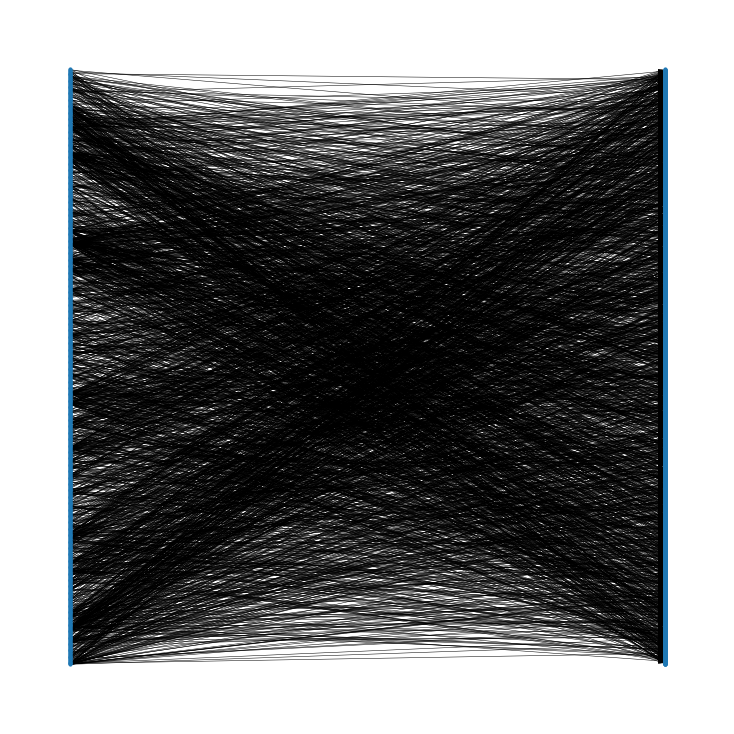

In [13]:
plt.figure(figsize=(10, 10))
nx.draw(G, pos=pos_bipartite, node_size= 10, width= 0.5)
plt.show()

However the bipartite graph has the drawback of bad edge length control, and it is therefore not well suited for a network with too many nodes and edges. The spring layout, when tuned correctly, offers a way better control of node disposition and edges lengths. Below is plotted the best manually tuned spring layout for this network.

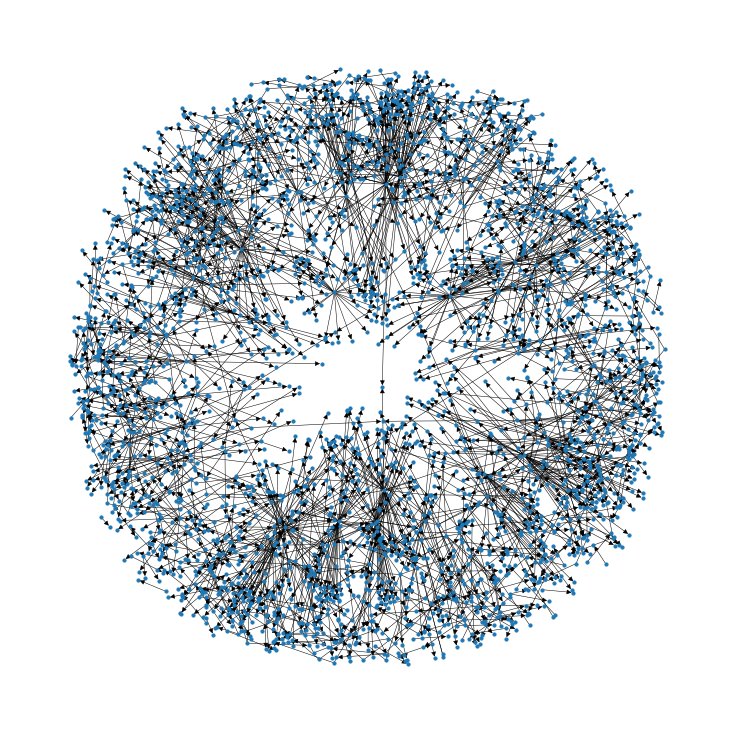

In [14]:
plt.figure(figsize=(10, 10))
nx.draw(G, pos=pos_spring, node_size= 10, width= 0.5)
plt.show()

By controlling the optimal distance between the nodes, the graph becomes interpretable:
* A big amount of customers orders from only one seller. Those customers are mostely represented in the peripheral area of the plot above.
* Similarly, most of the sellers are receiving orders from only one customer. However, there seems to be around 20 "important" sellers that send items to more than 10 different customers.

From these two observations, it is already possible to clusters the sellers into two groups. The first group of sellers has a very limited amount of customers represents the majority of the total number of sellers. The second group of sellers, on the other hand, has a larger number of customers but represents only a minority of the total number of sellers.

__The experimentation with the various layouts and their parameters has led to the choice of the `nx.spring_layout` for the next visualizations.__

In [15]:
pos = pos_spring.copy()

### <font color=orange>2.3:</font> Visualization and observations

The color palette defined below will be used for coloring the edges based on the value of the delivery KPI.

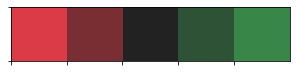

In [16]:
color_palette = sns.diverging_palette(10, 133, l=50, n=5, center="dark").as_hex()
sns.palplot(color_palette)

To assign edge colors according to either the review score, the delivery time or the delivery distance, a function computing the [percentiles](https://en.wikipedia.org/wiki/Percentile) and returning the edges colors serie is defined.

In [17]:
def get_edge_colors(network, color_attribute):
    colors_palette = sns.diverging_palette(10, 133, l=50, n=5, center="dark").as_hex()
    
    if color_attribute == 'review_score':
        ecolors = network.review_score.apply(lambda r: colors_palette[r-1])
        
    elif color_attribute == 'delivery_time_days':
        quantiles = network.delivery_time_days.quantile([0.2, 0.4, 0.6, 0.8]).values
        ecolors = network.delivery_time_days.apply(lambda t: colors_palette[4-np.searchsorted(quantiles, t)])
        
    elif color_attribute == 'delivery_distance_km':
        quantiles = network.delivery_distance_km.quantile([0.2, 0.4, 0.6, 0.8]).values
        ecolors = network.delivery_distance_km.apply(lambda t: colors_palette[4-np.searchsorted(quantiles, t)])        
          
    else: 
        ecolors = len(network)*['k']
        
    return ecolors

The network is now plotted with an interactive drop-down button to select according to what KPI the edges should be colored. An interpretation guide of the plot is provided below.

__Important__: for the interactive widget to work, the notebook needs a kernel. Therefore, if you wish to use the widget, please run the entire notebook in iPython (total running time ~ 1 min).

In [18]:
#Define parameters
N = len(network)
nlist = network.seller_id.append(network.customer_id)
ncolors  = N*['k'] + N*['b']
elist = [tuple(x) for x in network[['seller_id', 'customer_id']].values]
ecolors = get_edge_colors(network, 'review_score')

def update_graph(KPI='review_score'):
    plt.figure(figsize=(12, 12))
    
    ecolors = get_edge_colors(network, KPI)
    nx.draw(G, pos=pos, arrows = False, alpha=1,
        nodelist=nlist, node_color=ncolors, node_size= 12, 
        edgelist=elist, edge_color=ecolors, width= 1)

#     timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")
#     plt.savefig(timestamp + '.png')
    
    plt.show()

#Add drop-down widget to select KPI
import ipywidgets as widgets
widgets.interact(update_graph, KPI=['review_score', 'delivery_time_days', 'delivery_distance_km']);

interactive(children=(Dropdown(description='KPI', options=('review_score', 'delivery_time_days', 'delivery_dis…

__Interpretation guide of the visualization__:
* Each seller node is colored in black, and each customer node is colored in blue
* Each edge represents an item shipped from the seller to the customer
* The edge color represents the value of the KPI selected in the drop-down button:
    * When selecting `review_score` as KPI, the edges are colored <font color=green> __green__ when the score is 5 (intense green) or 4 (dark green)</font>, __black__ when the score is 3, and <font color=red> __red__ when the score is 2 (dark red) or 1 (intense red)</font>.
    * Similarly, when selecting the `delivery_time_days` KPI,  the edges are colored colored <font color=green> __green__ when the delivery time is among the 20% shortest delivery times (intense green) or among the 20% to 40% shortest delivery times (dark green)</font>, __black__ when the delivery time is among the 40% to 60% shortest delivery times, and <font color=red> __red__ when the delivery time is among the 20 to 40% longest delivery times (dark red) or among the 20% longest delivery times (intense red)</font>.
    * Similarly, when selecting the `delivery_distance_km` KPI,  the edges are colored <font color=green> __green__ when the delivery distance is among the 20% shortest delivery distance (intense green) or among the 20% to 40% shortest delivery distances (dark green)</font>, __black__ when the delivery distance is among the 40% to 60% shortest delivery distances, and <font color=red> __red__ when the delivery distance is among the 20 to 40% longest delivery distances (dark red) or among the 20% longest delivery distances (intense red)</font>.


__Observations from the visualization__:

For the important sellers (linked to more than 10 different customers), three main delivery performance profiles can be distinguished:
1. __Delivery excellence__: a seller with mainly positive KPIs. This is the case for a seller that combines high ratings, short delivery times and short delivery distances. In the network visualization, this delivery profile is characterized by a significant majority of green edges for every KPI selected in the drop-down button. __Currently, it seems that only one important seller achieves this delivery performance__.
2. __Mitigated delivery__: a seller with both positive and negative KPIs. This is the case for a seller that has both strengths and weaknesses in his delivery performance. In the visualization, this is characterized by a mix of green, black and red edges for at least two of the KPIs selected. __Currently, it seems that most important sellers fall within this category__.
3. __Poor delivery__: a seller with mainly negative KPIs. This is the case for a seller that has bad review scores as well as strong weaknesses in terms of delivery times and distances. It is characterized in the visualization by a vast majority of red edges for every KPI selected. __Currently, it fortunately seems that only one sellers is in that case__.

For less important sellers (only one or two customers), it is harder to make general observations.

## <font color=orange>3: </font> Delivery network optimization

It is now time to investigate a way to improve the delivery performance and the customer satisfaction.

From the previous network visualization, two other important observations about the link between the KPIs can be made:
* A short delivery time generally seems to be linked to a good customer review,
* A short delivery distance generally seems to be linked to a short delivery time.

__These observations can be verified by plotting the heatmaps of the KPIs against each other. For doing so, the delivery times and delivery distances will be attributed a score based on the their distribution [percentiles](https://en.wikipedia.org/wiki/Percentile). In the same way than with the edge color attribution, the scores will have a 5-level grade-scale (1: worst, 5: best)__.

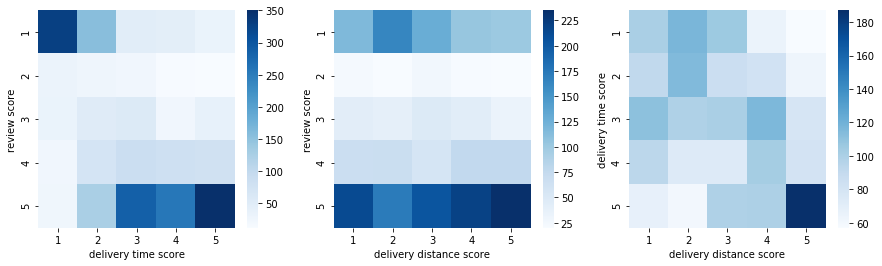

In [19]:
scores = [1, 2, 3, 4, 5]

dt_quantiles = network.delivery_time_days.quantile([0.2, 0.4, 0.6, 0.8]).values
network['delivery_time_score'] = network.delivery_time_days.apply(lambda t: scores[4-np.searchsorted(dt_quantiles, t)])

dd_quantiles = network.delivery_distance_km.quantile([0.2, 0.4, 0.6, 0.8]).values
network['delivery_distance_score'] = network.delivery_distance_km.apply(lambda t: scores[4-np.searchsorted(dd_quantiles, t)])


fig, axs = plt.subplots(1, 3, figsize=(15,4))
subsets = [['review_score', 'delivery_time_score'], ['review_score', 'delivery_distance_score'], ['delivery_time_score', 'delivery_distance_score']]

for s in range(3):
    table = network.groupby(subsets[s]).count()[['seller_id']].unstack(level=-1)
    sns.heatmap(table.values, cmap=plt.cm.Blues, ax=axs[s])
    axs[s].set_ylabel(subsets[s][0].replace('_', ' '))
    axs[s].set_xlabel(subsets[s][1].replace('_', ' '))
    axs[s].set_xticklabels(scores)
    axs[s].set_yticklabels(scores)

# plt.savefig('Delivery scores heatmap.png')
plt.show()

The heatmaps confirm the observations from the network visualization: 
* many deliveries with a high delivery time score (i.e. short delivery time) do also have a good review score (cf. left-hand side heatmap),
* many deliveries with a high delivery distance score (i.e. short delivery distance) do also have a good delivery time score (cf. right-hand side heatmap). 

__Consequently, an effective strategy for delivery network optimization should be to reduce the delivery distance in order to improve the delivery times and avoid customer unsatisfaction__.

Using the findings above, a strategy for optimizing the delivery distance will be implemented and evaluated. The following assumption will be made: if a seller shipped an item from a specific product category, then he can sell all other items in the same product category. Based on this assumption, the strategy will be to assign the geographically closest suitable seller to customers with the 40% longest travel distances.

A function to get the optimized seller distance is defined.

In [20]:
def get_opt_seller_distance(network, x):
    seller_id, customer_id, delivery_distance_score, product_category, delivery_distance  = x
    
    if delivery_distance_score > 2:
        return delivery_distance
    else:
        #Find customer coordinates
        customer_lat = network[network['customer_id'] == customer_id].customer_lat.mean()
        customer_lng = network[network['customer_id'] == customer_id].customer_lng.mean()

        #Find closest seller offering the same product category
        product_network = network[network['product_category_name'] == product_category].copy()
        product_network.loc[:,'customer_lat'] = customer_lat
        product_network.loc[:,'customer_lng'] = customer_lng
        product_network['delivery_distance_km'] = product_network[['seller_lat', 'seller_lng', 'customer_lat', 'customer_lng']].apply(get_distance, axis=1)
        closest_seller_distance = product_network.delivery_distance_km.min()
#         closest_seller_id = product_network[product_network['delivery_distance_km'] == closest_seller_distance][:1].seller_id.values[0]

        return closest_seller_distance

A new, optimized delivery distance is computed.

In [21]:
data = network[['seller_id', 'customer_id', 'delivery_distance_score', 'product_category_name', 'delivery_distance_km']].copy()
network['opt_delivery_distance_km'] = data.apply(lambda x: get_opt_seller_distance(network.copy(), x),  axis=1)

The optimized delivery distance scores are calculated __based on the current delivery distance quantiles__.

In [22]:
scores = [1, 2, 3, 4, 5]

dd_quantiles = network.delivery_distance_km.quantile([0.2, 0.4, 0.6, 0.8]).values
network['opt_delivery_distance_score'] = network.opt_delivery_distance_km.apply(lambda t: scores[4-np.searchsorted(dd_quantiles, t)])

Finally, it is possible to measure how much this optimization strategy can improve the delivery network, both in terms of delivery distance and delivery distance scores.

In [23]:
distance_decrease = (network['delivery_distance_km'] - network['opt_delivery_distance_km'])/network['delivery_distance_km']
print("Potential delivery distance decrease:", distance_decrease.mean()*100, "%")

score_increase = network.groupby('opt_delivery_distance_score').count() - network.groupby('delivery_distance_score').count()
print("Potential new delivery distance scores:", score_increase['customer_id'].to_dict())

Potential delivery distance decrease: 34.18380206797025 %
Potential new delivery distance scores: {1: -461, 2: -454, 3: 14, 4: 26, 5: 875}


This shows that the suggested delivery optimization strategy has the potential to reduce the total delivery distance by 34% and get 875 more items delivered with a short delivery distance (delivery distance score of 5).

## Conclusion

From the conducted network analysis, several key-takeaways can be given:
1. Sellers can be clustered into different profiles. This should enable network optimization strategies to be targeted towards the seller profiles that present the highest potential for improvements. In our case, these profiles are the sellers delivering to more than 10 customers than have mainly negative KPIs.
2. Bearing these profiles in mind, a network optimization strategy can be defined in order to improve the customer satisfaction. Indeed, the studies show that short delivery distances are often linked to short delivery times, and that short delivery times are often linked to positive customer reviews.
3. Finally, simulations based on the strategy defined showed significant potential improvements of the delivery distance.